In [2]:
!pip install mtranslate

In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from mtranslate import translate


In [4]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Enter a valid Hespress URL: https://www.hespress.com/%d8%a5%d8%b3%d8%b1%d8%a7%d8%a6%d9%8a%d9%84-%d8%aa%d8%b1%d9%81%d8%b6-%d9%85%d8%ae%d8%b1%d8%ac%d8%a7%d8%aa-%d8%a7%d9%84%d9%82%d9%85%d8%a9-%d8%a7%d9%84%d8%b9%d8%b1%d8%a8%d9%8a%d8%a9-1523456.html
Title: 1
Comment: وماذا ستقدم هذه القمة لفلسطين غير الصراخ والكلام .
Likes: -1
Sentiment: Negative
Score: -0.3818
User: محمد


Title: 2
Comment: حماس ارتكبت اكبر خطأ بهجومها في السابع من اكتوبر و الان المتضرر هم الفلسطينيون غزة اصبحت مدينة الاشباح الفقر الجوع الأمراض الاوبئة اكثر من 50 الف قتيل و 100 الف جريح,الغزاويين محاصرين من كل الجوانب و تأتي في الاخير حماس تقول انتصرنا بعدما خرجت من جحورها و تركت  من قبل الغزاويين يواجهون مصيرهم بأيديهم امام العدو الذي لا يرحم، هل تبادل بضعة اسرى مقابل قتل 50 ألف فلسطيني  100 الف جريح و مليون متشرد يسمى انتصار بالله عليكم احترموا عقولنا 
Likes: 0
Sentiment: Negative
Score: -0.9451
User: نورالدين


Title: 3
Comment: هه الأونروا تعتمد الفساد هراء تتحدث به اسرئيل التي تعد أكبر فاسد في المنطقة تسفك الدماء تقتل

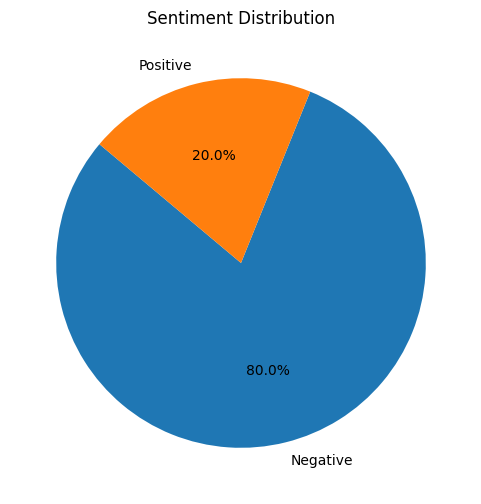

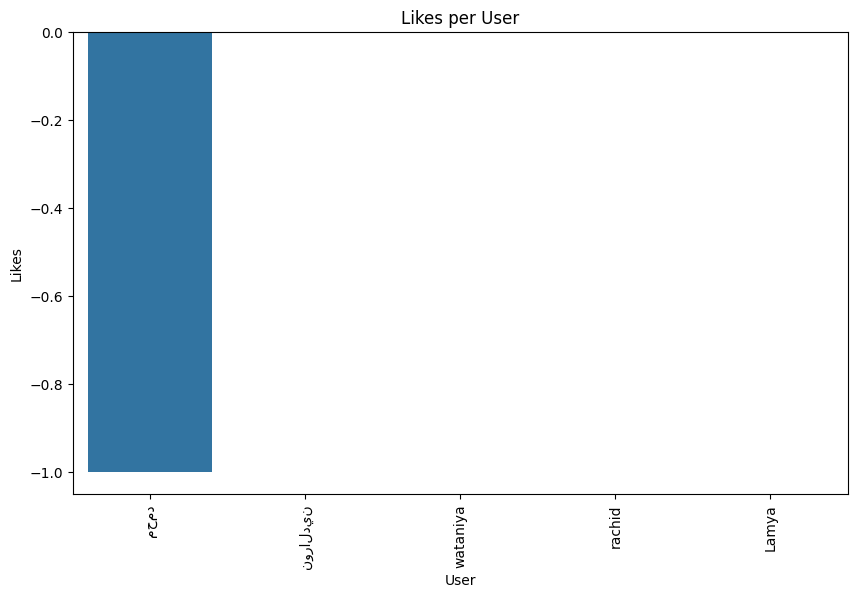

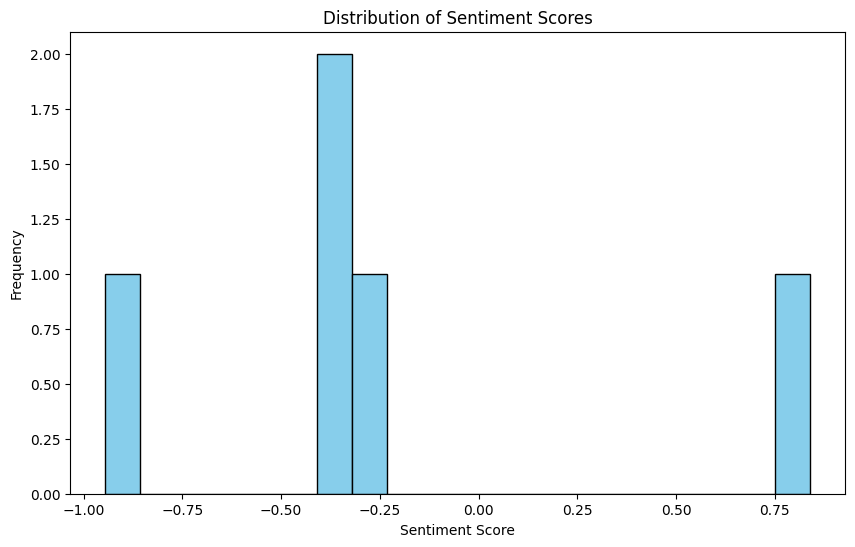

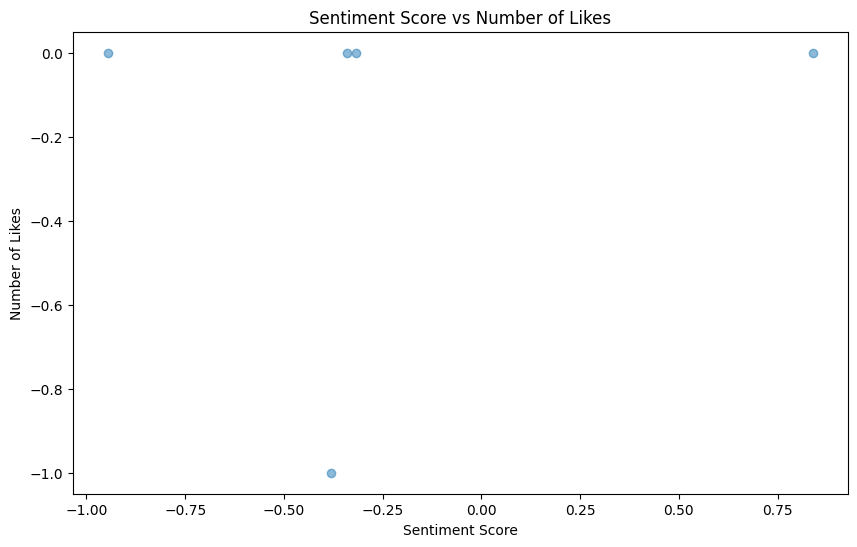

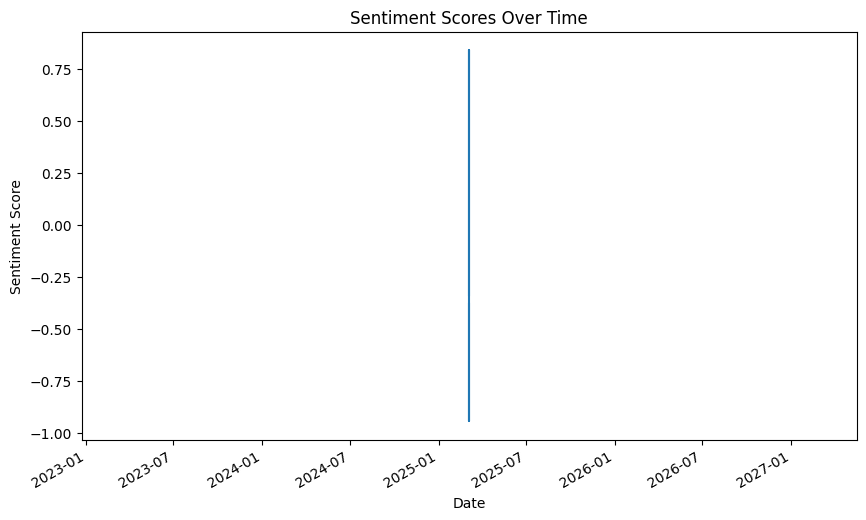

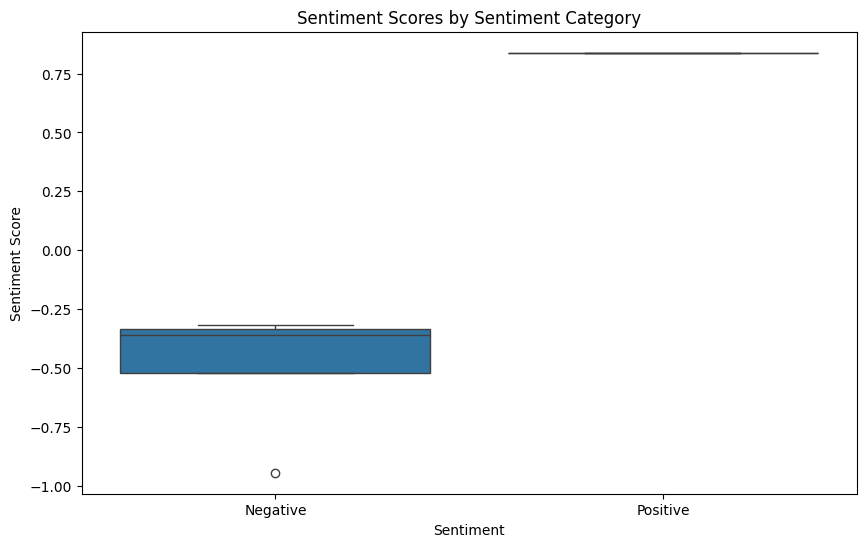

In [5]:


def is_valid_url(url):
    return url.startswith("https://www.hespress.com/")


def translate_month(arabic_month):
    arabic_to_english = {
        'يناير': 'January', 'فبراير': 'February', 'مارس': 'March', 'أبريل': 'April',
        'ماي': 'May', 'يونيو': 'June', 'يوليوز': 'July', 'غشت': 'August',
        'شتنبر': 'September', 'أكتوبر': 'October', 'نونبر': 'November', 'دجنبر': 'December'
    }
    return arabic_to_english.get(arabic_month, 'Unknown')

def fetch_comments(url):
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")

    comments = []
    comment_section = soup.find('ul', class_='comment-list hide-comments')
    if comment_section:
        for comment in comment_section.find_all('li', class_='comment'):
            user = comment.find('span', class_='fn heey').text if comment.find('span', class_='fn heey') else 'Unknown'
            text = comment.find('p').text if comment.find('p') else 'No comment text found'
            date_text = comment.find('div', class_='comment-date').text.strip() if comment.find('div', class_='comment-date') else 'Unknown date'
            date_parts = date_text.split()
            if len(date_parts) == 5:  # If time component is present
                date = pd.Timestamp(datetime.strptime(f"{date_parts[1]} {translate_month(date_parts[2])} {date_parts[3]} {date_parts[4]}", '%d %B %Y %H:%M'))
            else:  # If time component is not present
                date = pd.Timestamp(datetime.strptime(f"{date_parts[1]} {translate_month(date_parts[2])} {date_parts[3]}", '%d %B %Y'))
            likes = int(comment.find('span', class_='comment-recat-number').text) if comment.find('span', 'comment-recat-number') else 0
            comments.append({'User': user, 'Text': text, 'Date': date, 'Likes': likes})

    return pd.DataFrame(comments)

def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    try:
        english_text = translate(text, 'en')
        scores = sid.polarity_scores(english_text)
        compound_score = scores['compound']
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        compound_score = 0

    if compound_score >= 0.2:
        return 'Positive', compound_score
    elif compound_score <= -0.2:
        return 'Negative', compound_score
    else:
        return 'Neutral', compound_score

def main():
    url = input("Enter a valid Hespress URL: ")
    if not is_valid_url(url):
        print("Invalid URL. Please enter a URL from 'https://www.hespress.com/'.")
        return

    comments_df = fetch_comments(url)
    comments_df['Sentiment'], comments_df['Sentiment Score'] = zip(*comments_df['Text'].apply(analyze_sentiment))

    for index, row in comments_df.iterrows():
        print(f"Title: {index+1}")
        print(f"Comment: {row['Text']}")
        print(f"Likes: {row['Likes']}")
        print(f"Sentiment: {row['Sentiment']}")
        print(f"Score: {row['Sentiment Score']}")
        print(f"User: {row['User']}")
        print("\n")

    sentiment_counts = comments_df['Sentiment'].value_counts()
    print(f"Positive: {sentiment_counts.get('Positive', 0)}")
    print(f"Negative: {sentiment_counts.get('Negative', 0)}")
    print(f"Neutral: {sentiment_counts.get('Neutral', 0)}")

    # Optional: Average sentiment score for each sentiment
    sentiment_means = comments_df.groupby('Sentiment')['Sentiment Score'].mean()
    print(f"Average Positive Score: {sentiment_means.get('Positive', 0)}")
    print(f"Average Negative Score: {sentiment_means.get('Negative', 0)}")
    print(f"Average Neutral Score: {sentiment_means.get('Neutral', 0)}")



    # Sentiment Distribution Pie Chart
    sentiment_counts = comments_df['Sentiment'].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Sentiment Distribution')
    plt.show()


    # Likes vs User
    plt.figure(figsize=(10, 6))
    sns.barplot(x='User', y='Likes', data=comments_df)
    plt.xticks(rotation=90)
    plt.title('Likes per User')
    plt.show()


    # Distribution of Sentiment Scores Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(comments_df['Sentiment Score'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()

     # Sentiment Score vs Number of Likes Scatter Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(comments_df['Sentiment Score'], comments_df['Likes'], alpha=0.5)
    plt.title('Sentiment Score vs Number of Likes')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Number of Likes')
    plt.show()

    # Time Series Plot of Sentiment Scores
    plt.figure(figsize=(10, 6))
    comments_df.set_index('Date')['Sentiment Score'].plot()
    plt.title('Sentiment Scores Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.show()

    # Box Plot of Sentiment Scores by Sentiment
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Sentiment', y='Sentiment Score', data=comments_df)
    plt.title('Sentiment Scores by Sentiment Category')
    plt.xlabel('Sentiment')
    plt.ylabel('Sentiment Score')
    plt.show()

if __name__ == "__main__":
    main()
